# 🎯 Notebook for ML Recommendations [MVP]

In [1]:
import os
import glob
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [2]:
def get_latest_matches_data():
    # Get all CSV files in output directory
    csv_files = glob.glob('../data/output/matches_export_*.csv')
    if not csv_files:
        raise FileNotFoundError("No CSV files found in output directory")
    
    # Get most recent file
    latest_file = max(csv_files, key=os.path.getctime)
    print(f"Selected latest matches file: {os.path.basename(latest_file)}")
    
    # Read CSV
    df = pd.read_csv(latest_file)
    print(f"Number of games: {df.shape[0]:,}")
    print(f"Number of columns: {df.shape[1]}")
    return df

In [3]:
# Load data
df = get_latest_matches_data()
df.head(2)

Selected latest matches file: matches_export_20250111_165545.csv
Number of games: 2,703
Number of columns: 36


,match_id,date,best_of,atp_tournament,tournament,series,surface,court,round,winner,...,l5,b365w,b365l,psw,psl,maxw,maxl,avgw,avgl,comments
0,2703,2024-11-17,3,65,Masters Cup,Masters Cup,Hard,Indoor,The Final,Sinner J.,...,NaN,1.14,5.5,1.17,5.24,1.20,5.70,1.15,5.22,Completed
1,2702,2024-11-16,3,65,Masters Cup,Masters Cup,Hard,Indoor,Semifinals,Sinner J.,...,NaN,1.05,11.0,1.06,12.48,1.07,12.48,1.05,9.58,Completed


### Auxiliary Functions

In [4]:
def basic_horizontal_barplot(values, labels, xaxis_label, title, xlim=None, figsize=None):
    """
    Creates a horizontal bar plot with a legend and percentage formatting.

    Args:
        values (list): Numerical values to plot.
        labels (list): Labels corresponding to the values.
        xaxis_label (str): Label for the x-axis.
        title (str): Title of the plot.
        xlim (tuple, optional): Limits for the x-axis. Defaults to None.
        figsize (tuple, optional): Figure size. Defaults to None.
    """
    # Possible colors to use - if not enough, colors are reused
    cs = ["coral", "tomato", "peachpuff", "orange", "gold", "firebrick", "peru", "khaki", "chocolate"]
    cs = cs * (len(values) // len(cs) + 1)

    # The figure
    if figsize is None:
        fig = plt.figure(figsize=(4, 3))
    else:
        fig = plt.figure(figsize=figsize, dpi=100)
    
    ax = fig.add_axes([0, 0, 1, 0.9])
    color = cs[:len(values)]
    
    # Plot the bars
    bars = ax.barh(range(len(values)), values, color=color)
    ax.set_yticks(range(len(values)))
    ax.set_yticklabels(labels)
    
    # Format x-axis as percentages with 1 decimal place
    #ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1f}%"))

    # Add legend
    for i, bar in enumerate(bars):
        ax.text(
            bar.get_width() + (xlim[1] * 0.01 if xlim else max(values) * 0.01),  # Slightly offset from the bar
            bar.get_y() + bar.get_height() / 2,  # Centered on the bar
            f"{values[i]:.1f}%",  # Value with 1 decimal
            va='center',
            ha='left'
        )

    # Set axis labels and title
    if xlim is not None:
        ax.set_xlim(xlim)
    plt.suptitle(title)
    ax.set_xlabel(xaxis_label)

    # Show the plot
    plt.show()

In [5]:
def calculate_rois(df, betting_houses):
    """
    Calculate ROI metrics for different betting houses.

    Args:
        df (pd.DataFrame): The input dataframe containing match data.
        betting_houses (list): List of betting house prefixes (e.g., ['b365', 'ps']).

    Returns:
        dict: A dictionary with ROIs for each betting house and strategy.
    """
    rois = {}

    for house in betting_houses:
        # Column names for the given betting house
        odds_win_col = f"{house}w"  # Winner odds column
        odds_lose_col = f"{house}l"  # Loser odds column

        # ROI for betting on the smallest odds
        roi_smallest_odd = (
            100 * (df[odds_win_col][df[odds_win_col] < df[odds_lose_col]].sum() - len(df)) / len(df)
        )

        # ROI for betting based on best ranking
        roi_best_ranking = (
            100 * (df[odds_win_col][df['winner_rank'] < df['loser_rank']].sum() - len(df)) / len(df)
        )

        # ROI for random betting (randomly sampling 50% of matches)
        random_sample = df.sample(len(df) // 2, random_state=42)
        roi_random = (
            100 * (random_sample[odds_win_col].sum() - len(df)) / len(df)
        )

        # Store results for the betting house
        rois[house] = {
            "roi_smallest_odd": roi_smallest_odd,
            "roi_best_ranking": roi_best_ranking,
            "roi_random": roi_random,
        }

    return rois

# 1. Exploratory Data Analysis

## 1.1 Comparison of some basic strategies and betting houses

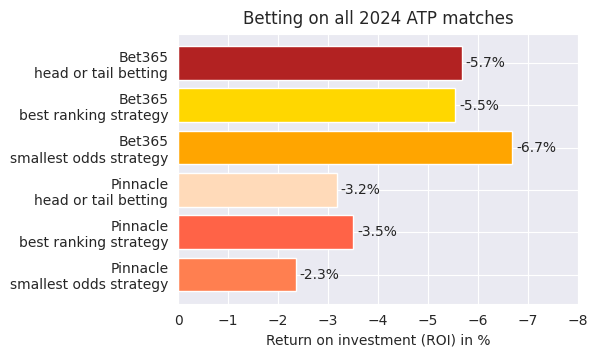

In [6]:
# Comparison of some basic strategies and betting houses
betting_houses = ['ps', 'b365']
roi_results = calculate_rois(df, betting_houses)

values = [
    roi_results['ps']['roi_smallest_odd'],     # ROI smallest odds for PS
    roi_results['ps']['roi_best_ranking'],     # ROI best ranking for PS
    roi_results['ps']['roi_random'],           # ROI random for PS
    roi_results['b365']['roi_smallest_odd'],   # ROI smallest odds for B365
    roi_results['b365']['roi_best_ranking'],   # ROI best ranking for B365
    roi_results['b365']['roi_random']          # ROI random for B365
]
labels=["Pinnacle\nsmallest odds strategy","Pinnacle\nbest ranking strategy","Pinnacle\nhead or tail betting",
        "Bet365\nsmallest odds strategy","Bet365\nbest ranking strategy","Bet365\nhead or tail betting"]
xaxis_label="Return on investment (ROI) in %"
title="Betting on all 2024 ATP matches"
basic_horizontal_barplot(values,labels,xaxis_label,title,[0,-8])

* It means that for 100 matches if we bet on the **Pinnacle**  using the **smallest odds strategy** we would still **loose 230 euros!**
* Pinnacle has a reputation of having the best odds. It seems to deserve well its reputation. A global loss of ~3% is very low. 
* On the contrary Bet365 seems to take a much higher commission than Pinnacle.

* One possible explanantion is that Bet365 is intended to more unexperienced gamblers. They might have noticed that their gamblers tend to overbet on the best ranked player, so to mitigate the risk they decrease the odds of the best ranked players. 

## 1.2 Maximum ROI betting on ALL Matches
Oly betting on matches we know in advance we'll win.

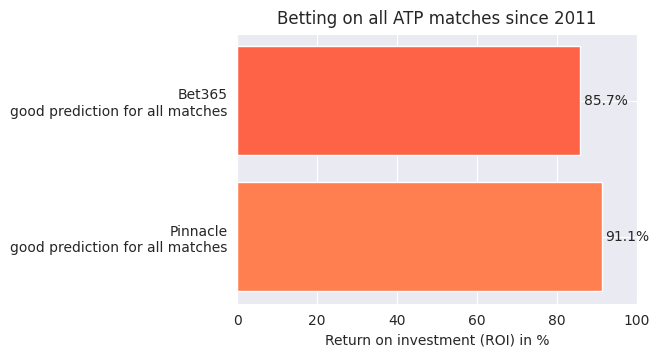

In [7]:
## Maximum possible ROI
max_roi_ps=100*(df.psw.sum()-len(df))/len(df)
max_roi_365=100*(df.b365w.sum()-len(df))/len(df)

values=[max_roi_ps,max_roi_365]
labels=["Pinnacle\ngood prediction for all matches","Bet365\ngood prediction for all matches"]
xaxis_label="Return on investment (ROI) in %"
title="Betting on all ATP matches since 2011"

basic_horizontal_barplot(values,labels,xaxis_label,title,[0,100])


## 1.3 Maximizig ROI by betting only on a selection of matches
Besides knowing the results in advance we will only bet on those we are especially confident

In [36]:
def profitComputation(percentage_matchs,conf,model_name="0"):
    """
    Given a confidence dataset and a percentage of matches, computes the ROI 
    if we bet only on the percentage of matches we have the most confidence in
    (same amount for each match).
    """
    coeff=percentage_matchs/100
    lim=int(coeff*len(conf))
    conf=conf.sort_values("confidence"+model_name,ascending=False)
    conf=conf.iloc[:lim,:]
    profit=100*(conf.psw[conf["win"+model_name]==1].sum()-len(conf))/len(conf)
    return profit

def plotProfits(conf,title=""):
    """
    Given a confidence dataset, plots the ROI according to the percentage of matches
    we bet on. 
    """
    profits=[]
    ticks=range(5,101)
    for i in ticks:
        p=profitComputation(i,conf)
        profits.append(p)
    fig=plt.figure(figsize=(7,4),dpi=100)
    plt.plot(ticks,profits)
    plt.xticks(range(0,101,5))
    plt.xlabel("% of matches we bet on")
    plt.ylabel("Return on investment (%)")
    plt.suptitle(title)
    plt.show()

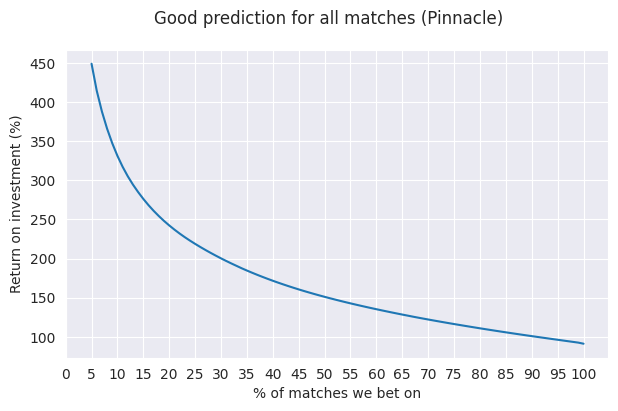

In [37]:
perfect_conf = pd.concat([df[["date", "psw", "psl"]]], axis=1)
perfect_conf["win0"] = [1] * len(perfect_conf)
perfect_conf["confidence0"] = perfect_conf.psw
plotProfits(perfect_conf,"Good prediction for all matches (Pinnacle)")

As we can see if we bet on 100% of the matches, and we are right each time, we find again the ROI we found above (91%).

But if we bet only on the matches we are the most confident in (in our ideal case the match with the highest odds) our ROI is much higher.

Betting on a subset of matches is in general a good strategy. It is hard to get a good ROI by betting on ALL matches, but it is feasible with a subset. The only limit being the percentage of matches we bet on. If it is too small, the number of matches we bet on is low and the ROI has a high variability.

In [40]:
1_000 * 0.2

200.0